# Objective

Investigates how spectral representations derived from an ERB-spaced cochlear model change under simulated reductions in frequency resolution.

Given paired cochleagrams computed from identical audio signals,

$$
C_{\text{baseline}} \quad \text{and} \quad C_{\text{degraded}},
$$

we examine whether a deterministic transformation

$$
F : C_{\text{degraded}} \rightarrow C_{\text{baseline}}
$$

can approximate the baseline representation.

The focus is not signal reconstruction, but the stability and recoverability of spectral structure under controlled model perturbations.

### Imports and Data loading

In [4]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve, hilbert

from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

y, fs = librosa.load("../KU.wav", sr=None)
print("Original fs:", fs)

target_fs = 16000
if fs != target_fs:
    y = librosa.resample(y, orig_sr=fs, target_sr=target_fs)
    fs = target_fs

y = y / (np.max(np.abs(y)) + 1e-9)
print("Using fs:", fs, "| samples:", len(y))

Original fs: 44100
Using fs: 16000 | samples: 2563855


### ERB helper functions (Hz ↔ ERB + centers)

In [5]:
def erb_hz(f):
    return 24.7 * (4.37 * f / 1000 + 1)

def erb_scale(f):
    return 21.4 * np.log10(1 + 0.00437 * f)

def inv_erb(e):
    return (10**(e / 21.4) - 1) / 0.00437

def erb_centers(fmin, fmax, n):
    e = np.linspace(erb_scale(fmin), erb_scale(fmax), n)
    return inv_erb(e)

### Gammatone impulse response

In [6]:
def gammatone(fs, fc, n=4, dur=0.08, bw_mult=1.0):
    t = np.arange(0, int(dur * fs)) / fs
    b = bw_mult * 1.019 * erb_hz(fc)
    g = t**(n - 1) * np.exp(-2 * np.pi * b * t) * np.cos(2 * np.pi * fc * t)
    g = g / (np.sqrt(np.sum(g**2)) + 1e-12)
    return g

### Cochleagram builder (band × frames)

In [ ]:
def build_cochleagram(
    y, fs,
    fmin=100, fmax=10000,
    N=32,
    bw_mult=1.0,
    hop_ms=10
):
    hop = int((hop_ms / 1000) * fs)
    centers = erb_centers(fmin, fmax, N)

    bands = []
    for fc in centers:
        g = gammatone(fs, fc, bw_mult=bw_mult)
        y_filt = fftconvolve(y, g, mode="same")
        env = np.abs(hilbert(y_filt))
        env = np.log1p(env)         
        env_frames = env[::hop]   
        bands.append(env_frames)

    C = np.vstack(bands)        
    return C, centers, hop

# Run it

In [ ]:
# Source ear (worse)
src = dict(N=19, bw_mult=3.0)

# Target ear (better / different)
tgt = dict(N=32, bw_mult=1.0) # "Normal-ish"
# tgt = dict(N=28, bw_mult=2.0) # "Moderate"
# tgt = dict(N=36, bw_mult=1.5) # "Mild-ish"

C_src, centers_src, hop = build_cochleagram(y, fs, N=src["N"], bw_mult=src["bw_mult"], hop_ms=10)
C_tgt, centers_tgt, _   = build_cochleagram(y, fs, N=tgt["N"], bw_mult=tgt["bw_mult"], hop_ms=10)

T = min(C_src.shape[1], C_tgt.shape[1])
C_src = C_src[:, :T]
C_tgt = C_tgt[:, :T]

print("C_src:", C_src.shape, "| C_tgt:", C_tgt.shape, "| hop(samples):", hop)

C_src: (19, 16025) | C_tgt: (32, 16025) | hop(samples): 160


# Turning the cochleargram into actual training data

In [ ]:
# X: (T, N_src), Y: (T, N_tgt)
X = C_src.T
Y = C_tgt.T

# Standardize
X_mu, X_sd = X.mean(axis=0, keepdims=True), X.std(axis=0, keepdims=True) + 1e-8
Y_mu, Y_sd = Y.mean(axis=0, keepdims=True), Y.std(axis=0, keepdims=True) + 1e-8

Xz = (X - X_mu) / X_sd
Yz = (Y - Y_mu) / Y_sd

print("Xz:", Xz.shape, "| Yz:", Yz.shape)

Xz: (16025, 19) | Yz: (16025, 32)


### The fun model building stuff
Fitting a Ridged mapping $C_{src}(t) \to C_{target}$

In [ ]:
Xtr, Xte, Ytr, Yte = train_test_split(
    Xz, Yz, test_size=0.2, random_state=0, shuffle=True
)

model = Ridge(alpha=1.0)
model.fit(Xtr, Ytr)

# Predict all frames
Yhat_z = model.predict(Xz)
Yhat = Yhat_z * Y_sd + Y_mu
C_hat = Yhat.T #(N_tgt, T)

mae = np.mean(np.abs(C_hat - C_tgt))
print("Frame-wise mapping MAE:", mae)

Frame-wise mapping MAE: 0.07285843590670384


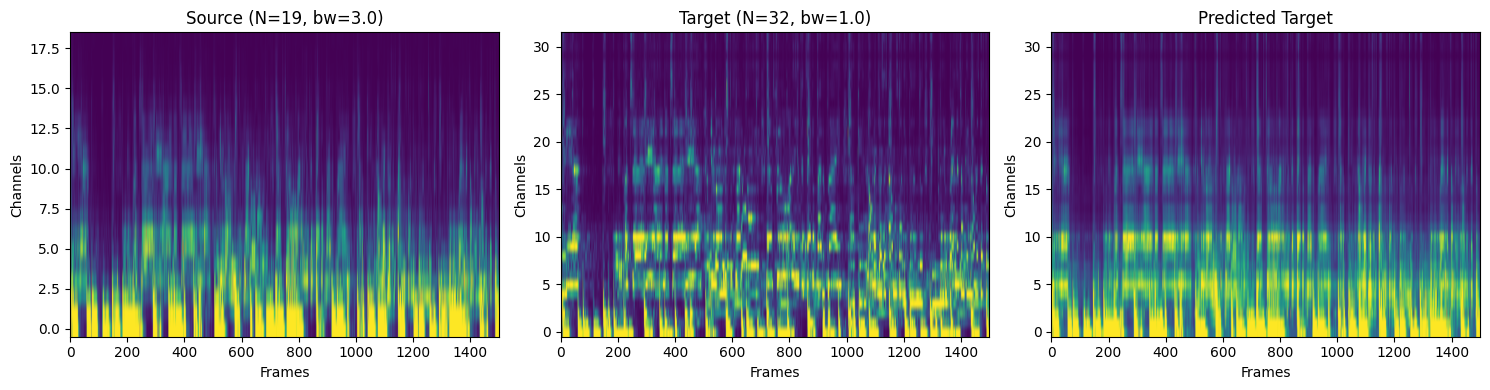

In [12]:
def show_triplet(C_src, C_tgt, C_hat, fs, hop, t0=30, t1=45):
    i0 = int((t0 * fs) / hop)
    i1 = int((t1 * fs) / hop)

    def im(ax, C, title):
        vmin = np.percentile(C, 5)
        vmax = np.percentile(C, 95)
        ax.imshow(C[:, i0:i1], aspect="auto", origin="lower", vmin=vmin, vmax=vmax)
        ax.set_title(title)
        ax.set_xlabel("Frames")
        ax.set_ylabel("Channels")

    fig, axs = plt.subplots(1, 3, figsize=(15, 4))
    im(axs[0], C_src, f"Source (N={C_src.shape[0]}, bw={src['bw_mult']})")
    im(axs[1], C_tgt, f"Target (N={C_tgt.shape[0]}, bw={tgt['bw_mult']})")
    im(axs[2], C_hat, "Predicted Target")
    plt.tight_layout()
    plt.show()

show_triplet(C_src, C_tgt, C_hat, fs, hop, t0=30, t1=45)

#### Energy Profile

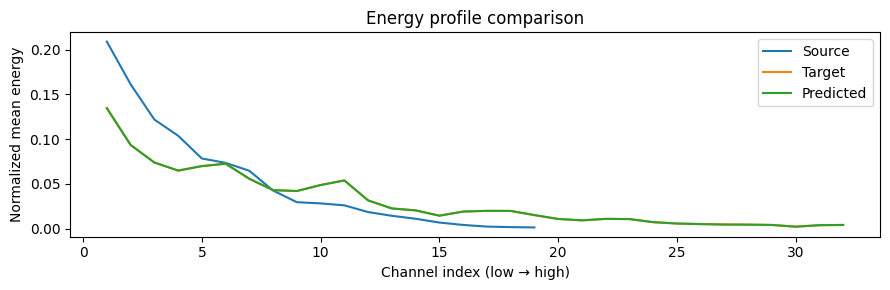

mean( predicted response - good ear response) = 0.07285843590670384


In [27]:
from IPython.display import  display, Markdown, HTML


def energy_profile(C):
    E = C.mean(axis=1)
    return E / (E.sum() + 1e-12)

E_src = energy_profile(C_src)
E_tgt = energy_profile(C_tgt)
E_hat = energy_profile(C_hat)

plt.figure(figsize=(9,3))
plt.plot(np.arange(1, len(E_src)+1), E_src, label="Source")
plt.plot(np.arange(1, len(E_tgt)+1), E_tgt, label="Target")
plt.plot(np.arange(1, len(E_hat)+1), E_hat, label="Predicted")
plt.xlabel("Channel index (low → high)")
plt.ylabel("Normalized mean energy")
plt.title("Energy profile comparison")
plt.legend()
plt.tight_layout()
plt.show()

print("mean( predicted response - good ear response) =", np.mean(np.abs(C_hat - C_tgt))) # 0.07285843590670384 So Target \approx Predicted

In [14]:
print("E_src:", E_src.shape)
print("E_tgt:", E_tgt.shape)
print("E_hat:", E_hat.shape)

print("Max difference Target vs Predicted:",
      np.max(np.abs(E_hat - E_tgt)))

E_src: (19,)
E_tgt: (32,)
E_hat: (32,)
Max difference Target vs Predicted: 0.00030455127413733796
